# NH Ralph LEISA Data from Jupiter
_Ben Kamphaus, PhD_

This time we hack around and get lost a little at the beginning, but finally get somewhere - getting spectral information from Jupiter!

In [2]:
import pyfits
import numpy as np
from matplotlib import pyplot as plt

In [3]:
pyfits.info("/Users/bkamphaus/data/fits/20070224_003466/lsb_0034663919_0x53c_sci_1.fit")

Filename: /Users/bkamphaus/data/fits/20070224_003466/lsb_0034663919_0x53c_sci_1.fit
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     285   (256, 256, 695)   float32   
1    WAVELENGTHS  ImageHDU         9   (256, 256, 2)   float32   
2    ANGLES      ImageHDU         9   (256, 256, 3)   float32   
3    FLATFIELD   ImageHDU         8   (256, 256)   float32   
4    CALIBRATION  ImageHDU         9   (256, 256, 2)   float32   
5    ERRORMAP    ImageHDU         8   (256, 256)   float32   
6    QUALITY     ImageHDU         8   (256, 256)   int16   
7    QUATERNIONS  ImageHDU        10   (5, 695)     float32   
8    HOUSEKEEPING  BinTableHDU    183   222R x 75C   [J, B, B, B, B, B, B, I, I, I, I, I, I, I, B, B, B, B, B, B, B, B, B, B, B, B, B, B, B, B, B, B, B, B, B, B, B, B, I, I, I, B, B, B, B, B, B, B, B, B, B, B, B, I, I, I, I, I, I, I, I, I, J, J, B, I, I, I, I, I, I, I, I, I, J]   


In [4]:
leisa_file = "/Users/bkamphaus/data/fits/20070224_003466/lsb_0034663919_0x53c_sci_1.fit"
img_cube, data_hdr = pyfits.getdata(leisa_file, 0, header=True)
img_cube = np.float32(img_cube)
wl = pyfits.getdata(leisa_file, 1)
g_o = pyfits.getdata(leisa_file, 4)

In [7]:
def cal(DN, gain, offset):
    return gain*DN + offset

In [65]:
def cal_all(img_cube, gain_offset):
    out = np.zeros_like(img_cube, dtype=np.float128)
    for i in range(np.shape(out)[0]):
        out[i] = cal(img_cube[i,:,:], gain_offset[1,:,:], gain_offset[0,:,:])
    return out

In [9]:
cal_cube = cal_all(img_cube, g_o)

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in multiply
  from IPython.kernel.zmq import kernelapp as app


Hmm, this worked fine for our previous dataset. What could be wrong?

In [10]:
np.max(img_cube)

nan

In [11]:
# Noooo! Do not want!
i_nan = np.where(np.isnan(img_cube))
img_cube[i_nan] = 0
cal_cube = cal_all(img_cube, g_o)

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in multiply
  from IPython.kernel.zmq import kernelapp as app


In [12]:
np.max(img_cube) # ok, this error was due to a really large value that we can't multiply for this dataset type
(np.max(img_cube), np.max(g_o), np.min(g_o))

(2.2192092e+16, 12.499763, 0.0)

In [13]:
i_max = np.where(img_cube == np.max(img_cube))
img_cube[i_max] = 0
np.max(img_cube)

2.2095221e+16

It's really doubtful that these high values are meaningful, but there are probably several bright pixels due to particles hitting the sensor or glitched pixels. I can try applying the bad data mask.

In [14]:
qf = pyfits.getdata(leisa_file, 6)
(np.shape(qf))
(np.max(img_cube[0, qf]), np.max(img_cube[0,:,:]))

(7.9028296e+13, 2.2095221e+16)

Well, high values are outside of the bad pixels.

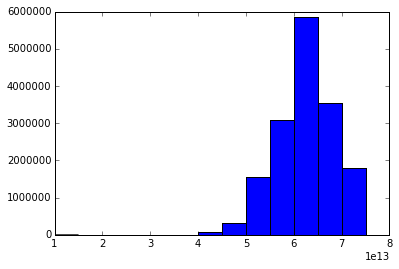

In [24]:
%matplotlib inline
plt.hist(np.ravel(img_cube[0, qf]), bins=np.arange(1e13,2e16,1e14))
plt.show()

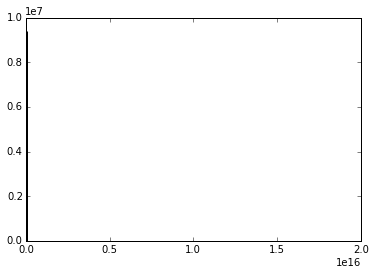

In [39]:
plt.hist(np.ravel(img_cube[0, qf]), bins=np.arange(1e13,2e16,1e13))
plt.show()

In [41]:
# Yeah, let's just play fast and loose right now and kill those high values
i_bright = np.where(img_cube[0,:,:] >= 2e16)
map(len, i_bright)

[8, 8]

In [46]:
img_cube = np.float64(img_cube)
img_cube_small = img_cube/1e10

/usr/local/lib/python2.7/site-packages/numpy/core/function_base.py:99: RuntimeWarning: invalid value encountered in multiply
  y = _nx.arange(0, num, dtype=dtype) * step + start
/usr/local/lib/python2.7/site-packages/numpy/core/function_base.py:99: RuntimeWarning: invalid value encountered in add
  y = _nx.arange(0, num, dtype=dtype) * step + start


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([              nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,  2209522.08835871]),
 <a list of 10 Patch objects>)

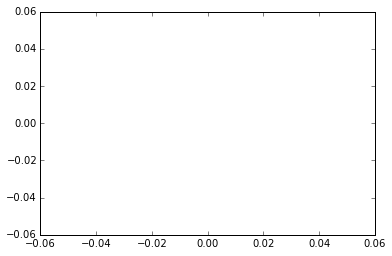

In [49]:
plt.hist(np.ravel(img_cube_small))

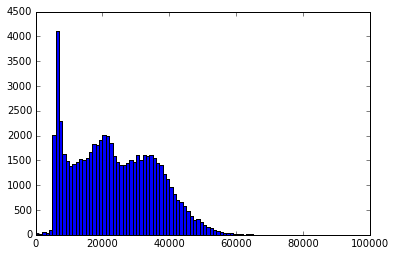

In [59]:
i_nan = np.where(np.isnan(img_cube_small))
img_cube_small[i_nan] = 0
plt.hist(np.ravel(img_cube_small[0,:,:]), np.arange(0.0,1e5,1e3))
plt.show()

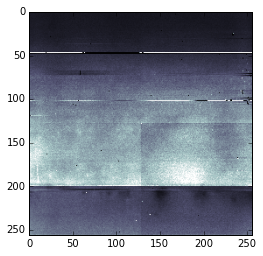

In [62]:
plt.imshow(img_cube_small[0,:,:], clim=(0.0,55000.), cmap='bone')

OK, this finally looks interesting. We're out of real units with the small image, so let's see if we can apply gains and offsets to the large image if we use quad-preicison floating point.

In [63]:
img128 = np.float128(img_cube)
i_nan = np.where(np.isnan(img128))
img128[i_nan] = 0.

In [71]:
go_i_nan = np.where(np.isnan(g_o))
g_o[go_i_nan] = 0.
g_o = np.float128(g_o) 

In [72]:
np.max(img128)

22095220883587072.0

In [73]:
np.shape(g_o)

(2, 256, 256)

In [81]:
(np.max(g_o[0,:,:]), np.min(g_o[0,:,:]))

(12.499762535095214844, 3.5714285373687744141)

In [82]:
(np.max(g_o[1,:,:]), np.min(g_o[1,:,:]))

(0.0, 0.0)

Well, I thought I had calibrate correct in the previous notebook, but I suppose not. A gain across the board of 0.0 makes no sense -- the same for offsets is reasonable if we're really in values that match some kind of meaningful units. This could be the case since the values are very high - much higher than you would expect if they were intended for an offset to be applied later as part of calibration.

In [85]:
# since we don't have to add an offset, we can go back to our smaller img_cube_small vals
(np.shape(img_cube_small), np.max(img_cube_small), np.min(img_cube_small))

((695, 256, 256), 2209522.0883587073, -inf)

In [86]:
i_inf = np.where(np.isinf(img_cube_small))
img_cube_small[i_inf] = 0.

In [87]:
def apply_gains(cube, gains):
    out = np.zeros_like(cube, dtype=np.float64)
    for i in range(np.shape(out)[0]):
        out[i,:,:] = out[i,:,:] * gains
    return out

In [94]:
img_cube_small_cal = apply_gains(img_cube_small, g_o[0,:,:])

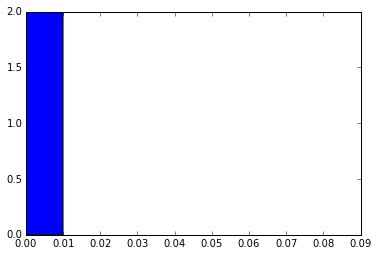

In [245]:
plt.hist(np.ravel(img_cube_small_cal[10,:,:]), bins=np.arange(0., 0.1, 0.01))
plt.show()

In [96]:
(np.max(img_cube_small_cal), np.min(img_cube_small_cal))

(0.0, 0.0)

At this point, I looked a few cells above where I defined `apply_gains` and realized I assigned the result of multiplying out and gains, not cube and gains. Oops!

In [105]:
def apply_gains(cube, gains):
    out = np.zeros_like(cube, dtype=np.float64)
    for i in range(np.shape(out)[0]):
        out[i,:,:] = cube[i,:,:] * gains
    return out

In [106]:
img_cube_small_cal = apply_gains(img_cube_small, g_o[0,:,:])

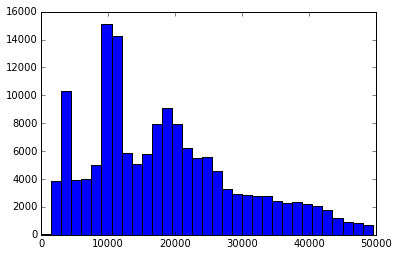

In [121]:
plt.hist(np.ravel(img_cube_small_cal[:,:,100]), bins=np.arange(0, 0.5e5, 1.5e3))
plt.show()

Whew, finally a reasonable looking histogram!

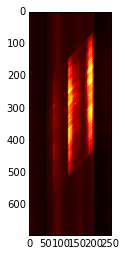

In [124]:
plt.imshow(img_cube_small_cal[:,:,100], clim=(0.,3.5e5), cmap='hot')

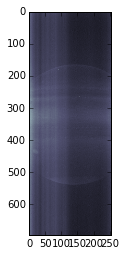

In [132]:
plt.imshow(img_cube_small_cal[:,100,:], clim=(500,1e5), cmap='bone')

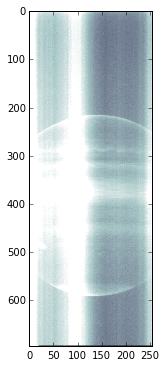

In [135]:
plt.figure(figsize=(6,6))
plt.imshow(img_cube_small_cal[:,50,:], clim=(500,1e4), cmap='bone')

That's right -- this is BIL, so the spectral information is in the second dimension (dimension indexed by 1).

These images won't be pretty -- that's what LORRI and MVIC are for. What we want, in this case, are image reference points to let us know where we can pull meaningful spectral information from the planetary body.

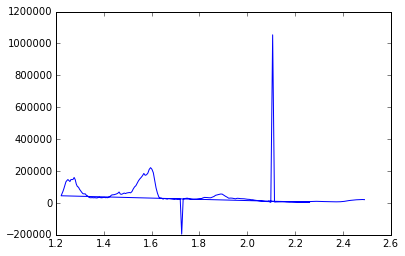

In [138]:
plt.plot(wl[0,:,200], img_cube_small_cal[375,:,200])
plt.show()

These wavelengths look correct, but this is the same issue we ran into previously where the wavelength sort is off.

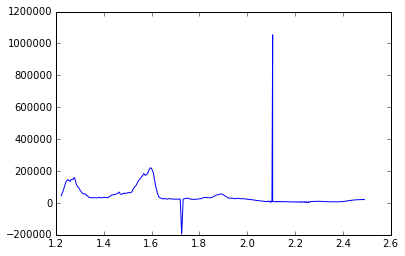

In [140]:
sort_i = np.argsort(wl[0,:,200])
plt.plot(wl[0,sort_i,200], img_cube_small_cal[375,sort_i,200])
plt.show()

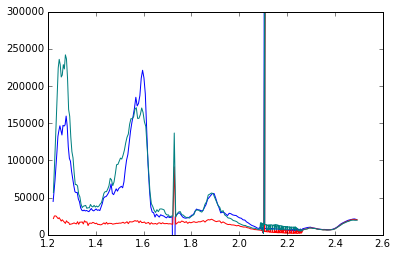

In [146]:
sort_i = np.argsort(wl[0,:,200])
plt.plot(wl[0,sort_i,200], img_cube_small_cal[375,sort_i,200], color='blue')
plt.plot(wl[0, sort_i,220], img_cube_small_cal[550,sort_i,220], color='red')
plt.plot(wl[0, sort_i,220], img_cube_small_cal[300,sort_i,220], color='teal')
plt.ylim(0,3e5)
plt.show()

We can now spot abpsorption, reflectance, and (maybe?) emissivity features! We definitely have some noisy and incorrect looking spectral information, though. One thing we forgot to do was filter down the data to only capture known good pixels. It's possible we may be able to kill some of the bad bands and only see valuable spectral information.

In [162]:
def apply_mask(img, qf):
    img_copy = np.copy(img)
    mult = np.int16(np.logical_not(qf))
    for i in range(np.shape(img_copy)[0]):
        img_copy[i,:,:] *= mult
    return img_copy

spec_cube = apply_mask(img_cube_small_cal, qf)

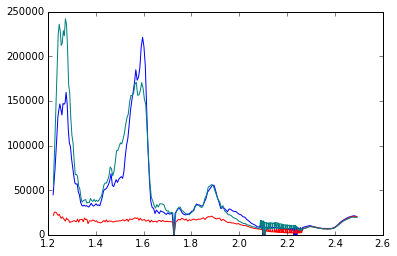

In [165]:
plt.plot(wl[0, sort_i, 200], spec_cube[375, sort_i, 200], color='blue')
plt.plot(wl[0, sort_i, 220], spec_cube[550, sort_i, 220], color='red')
plt.plot(wl[0, sort_i, 220], spec_cube[300, sort_i, 220], color='teal')
plt.show()

Much improved! 0's aren't a perfect "no data" value, but really everything is kind of crap. `0`, Arbitrary numbers like `-9999.9`, `NaN` all have their problems. Here we can at least filter out 0's on the fly when necessary and be pretty sure they're not a real, empirical 0.

Look at the plot above -- notice the "peaks" in two of the spectra around 1.3, 1.6, and 1.9-ish?

In [170]:
def get_wl_match(wl_array, target_wl):
    """
    Pass a spectrum and a wl, returns the index of the closest wavelength to the target
    wavelength value.
    """
    i_match = np.argmin(np.abs(wl_array - target_wl))
    return i_match

# We're just eyeballing it here, but we'd really want to look at, e.g., local min/max
# from numerical derivative, or just min/max across a range.
(get_wl_match(np.ravel(wl[0, :, 220]), 1.3),
 get_wl_match(np.ravel(wl[0, :, 220]), 1.6),
 get_wl_match(np.ravel(wl[0, :, 220]), 1.9))

(181, 124, 76)

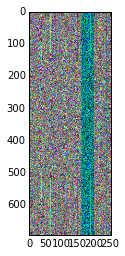

In [173]:
# need to get color interleave in right dims/shape for imshow
bip = np.transpose(spec_cube, (0, 2, 1))
bip_disp = bip[:,:,[181,124,76]]

plt.imshow(bip_disp)
plt.show()

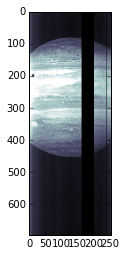

In [193]:
plt.imshow(bip_disp[:,:,0], clim=(0, 2e5), cmap='bone')
plt.show()

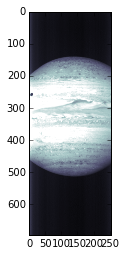

In [251]:
plt.imshow(bip_disp[:,:,1], clim=(0, 2.5e5), cmap='bone')
plt.show()

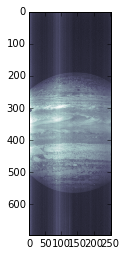

In [192]:
plt.imshow(bip_disp[:,:,2], clim=(0, 1e5), cmap='bone')
plt.show()

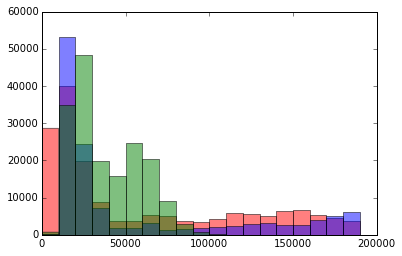

In [202]:
# Yikes, no good. Let's figure out image stretch.
from scipy.misc import bytescale

plt.hist(np.ravel(bip_disp[:,:,0]), bins=np.arange(0, 2e5, 1e4), color='red', alpha=0.5)
plt.hist(np.ravel(bip_disp[:,:,1]), bins=np.arange(0, 2e5, 1e4), color='blue', alpha=0.5)
plt.hist(np.ravel(bip_disp[:,:,2]), bins=np.arange(0, 2e5, 1e4), color='green', alpha=0.5)
plt.show()

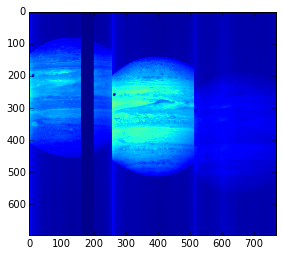

In [207]:
plt.imshow(np.hstack((bip_disp[:,:,0], bip_disp[:,:,1], bip_disp[:,:,2])))
plt.show()

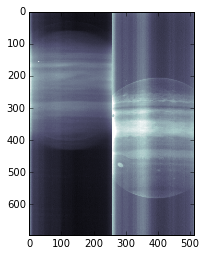

In [244]:
plt.imshow(np.hstack((spec_cube[:,230,:],spec_cube[:,60,:])),
                      vmin=0, vmax=3e4, cmap='bone')

I can tell from the images above that the spectral dimension of the data does not well match Jupiter's position. That is, a spectral slice of the data will be getting different materials as Jupiter moves vertically across the data as we move through the data's spectral axis.

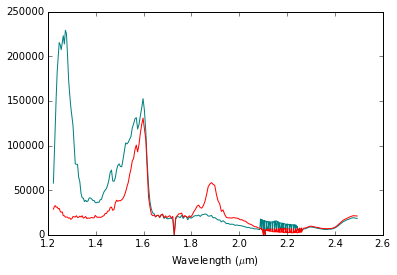

In [250]:
plt.plot(wl[0, sort_i, 220], spec_cube[200, sort_i, 220], color='teal')
plt.plot(wl[0, sort_i, 220], spec_cube[450, sort_i, 220], color='red')
plt.xlabel("Wavelength ($\mu$m)")
plt.show()